In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

In [2]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

In [4]:
df = pd.read_csv('../../data/df.csv')
df.head()

,player_id,season,goals,assists,yellow_cards,red_cards,minutes_played,avg_attendance,matches_played,player_club_id,market_value_in_eur,player_club_domestic_competition_id,club_id,club_name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,name,height_in_cm,country_of_citizenship,country_of_birth,date_of_birth,position,sub_position,foot,highest_market_value_in_eur,season_age
0,342229,2018,37,14,7,1,3030,41067.0,37,583,200000000,FR1,583.0,Fc Paris Saint Germain,FR1,NaN,29.0,25.3,18.0,62.1,14.0,Parc des Princes,49691.0,€-93.20m,Christophe Galtier,Kylian Mbappé,178,France,France,1998-12-20,Attack,Centre-Forward,Right,200000000.0,20.0
1,342229,2019,24,12,2,0,2051,40012.0,28,583,200000000,FR1,583.0,Fc Paris Saint Germain,FR1,NaN,29.0,25.3,18.0,62.1,14.0,Parc des Princes,49691.0,€-93.20m,Christophe Galtier,Kylian Mbappé,178,France,France,1998-12-20,Attack,Centre-Forward,Right,200000000.0,21.0
2,28003,2017,45,20,7,0,4468,53053.0,54,131,180000000,FR1,131.0,Fc Barcelona,ES1,NaN,24.0,25.3,10.0,41.7,19.0,Spotify Camp Nou,99354.0,€-118.00m,Xavi,Lionel Messi,170,Argentina,Argentina,1987-06-24,Attack,Right Winger,Left,180000000.0,30.0
3,68290,2018,20,10,4,0,1990,39808.0,24,583,180000000,FR1,583.0,Fc Paris Saint Germain,FR1,NaN,29.0,25.3,18.0,62.1,14.0,Parc des Princes,49691.0,€-93.20m,Christophe Galtier,Neymar,175,Brazil,Brazil,1992-02-05,Attack,Left Winger,Right,180000000.0,26.0
4,68290,2017,25,16,8,0,2427,42564.0,27,583,180000000,FR1,583.0,Fc Paris Saint Germain,FR1,NaN,29.0,25.3,18.0,62.1,14.0,Parc des Princes,49691.0,€-93.20m,Christophe Galtier,Neymar,175,Brazil,Brazil,1992-02-05,Attack,Left Winger,Right,180000000.0,25.0


In [5]:
columns_to_drop = ['player_club_domestic_competition_id', 'domestic_competition_id', 'total_market_value', 'stadium_name',
                   'net_transfer_record', 'name', 'country_of_birth', 'date_of_birth', 'club_id', 'highest_market_value_in_eur']
df = df.drop(columns_to_drop, axis=1)

In [6]:
# drop rows where club is NaN
df = df.dropna(subset=['club_name'])
# fill average_age with mean
df['average_age'] = df['average_age'].fillna(df['average_age'].mean())
df['foreigners_percentage'] = df['foreigners_percentage'].fillna((df['foreigners_number']/df['squad_size'] * 100).round(1))
df.isna().sum()

player_id                    0
season                       0
goals                        0
assists                      0
yellow_cards                 0
red_cards                    0
minutes_played               0
avg_attendance               0
matches_played               0
player_club_id               0
market_value_in_eur          0
club_name                    0
squad_size                   0
average_age                  0
foreigners_number            0
foreigners_percentage     1901
national_team_players        0
stadium_seats                0
coach_name                   0
height_in_cm                 0
country_of_citizenship       0
position                     0
sub_position              5078
foot                      1011
season_age                  15
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
# define categorical features
categorical_features = ['club_name', 'coach_name', 'country_of_citizenship', 'position', 'sub_position','foot']
df[categorical_features] = df[categorical_features].astype('category')

In [13]:
df.dtypes

player_id                    int64
season                       int64
goals                        int64
assists                      int64
yellow_cards                 int64
red_cards                    int64
minutes_played               int64
avg_attendance             float64
matches_played               int64
player_club_id               int64
market_value_in_eur          int64
club_name                 category
squad_size                 float64
average_age                float64
foreigners_number          float64
foreigners_percentage      float64
national_team_players      float64
stadium_seats              float64
coach_name                category
height_in_cm                 int64
country_of_citizenship    category
position                  category
sub_position              category
foot                      category
season_age                 float64
dtype: object

In [14]:
# split data into train and test, train is every season before 2022
train = df[df['season'] < 2022]
test = df[df['season'] == 2022]

x_train = train.drop(['market_value_in_eur'], axis=1)
y_train = train['market_value_in_eur']
x_test = test.drop(['market_value_in_eur'], axis=1)
y_test = test['market_value_in_eur']
y_train = np.log10(y_train + 1)

In [16]:
model = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    thread_count=-1,
    max_depth=6,
    silent=True,
    loss_function='RMSE',
    random_seed=42,
    bagging_temperature=0.3,
    od_type="Iter"
)

In [17]:
model.fit(x_train, y_train, cat_features=categorical_features)

Text(0.5, 1.0, 'Feature Importance')

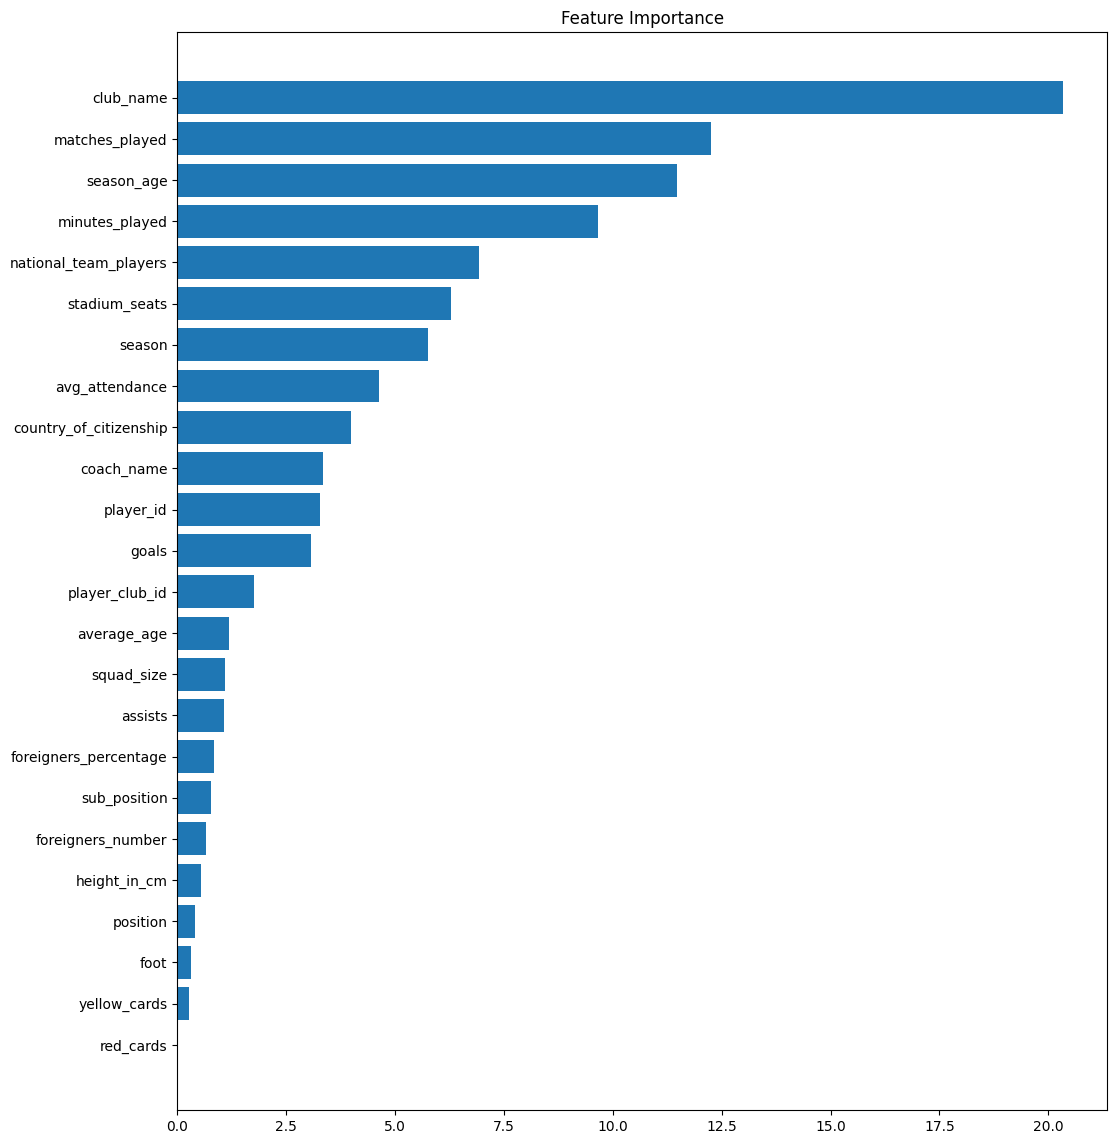

In [18]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 14))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.drop(['market_value_in_eur'], axis = 1).columns)[sorted_idx])
plt.title('Feature Importance')

In [19]:
pred = model.predict(x_test)
pred = 10**(pred) - 1
pred[pred < 0] = pred.mean()
cat_rmsle = round(rmsle(y_test, pred), 2)
print('Test RMSLE:', cat_rmsle)

Test RMSLE: 0.64
